In [171]:
# 1. Importar librerías necesarias

import os
os.environ["OMP_NUM_THREADS"] = "4"  # Limita los hilos para evitar memory leak en Windows

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



# Para mostrar gráficos en Jupyter Notebook
%matplotlib inline

# 2. Cargar el dataset (asegúrate de tener la ruta correcta)
dataset = pd.read_csv('archivo_gym_members_exercise_tracking_version2.csv')

### Paso 3. Seleccion de las variables fisicas que se usaran para clustering. Normalización explícita de las variables

In [172]:
# 3. Seleccionar las variables físicas que usaremos para clustering
features = ['Age', 'Gender', 'Weight (kg)', 'Height (m)', 'BMI', 'Fat_Percentage', 'Experience_Level', 'Workout_Frequency (days/week)']
X = dataset[features]

# Aplicamos StandardScaler a las variables, para que todas estén en la misma escala.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Paso 4 - Métricas de K-means para elegir K optimo


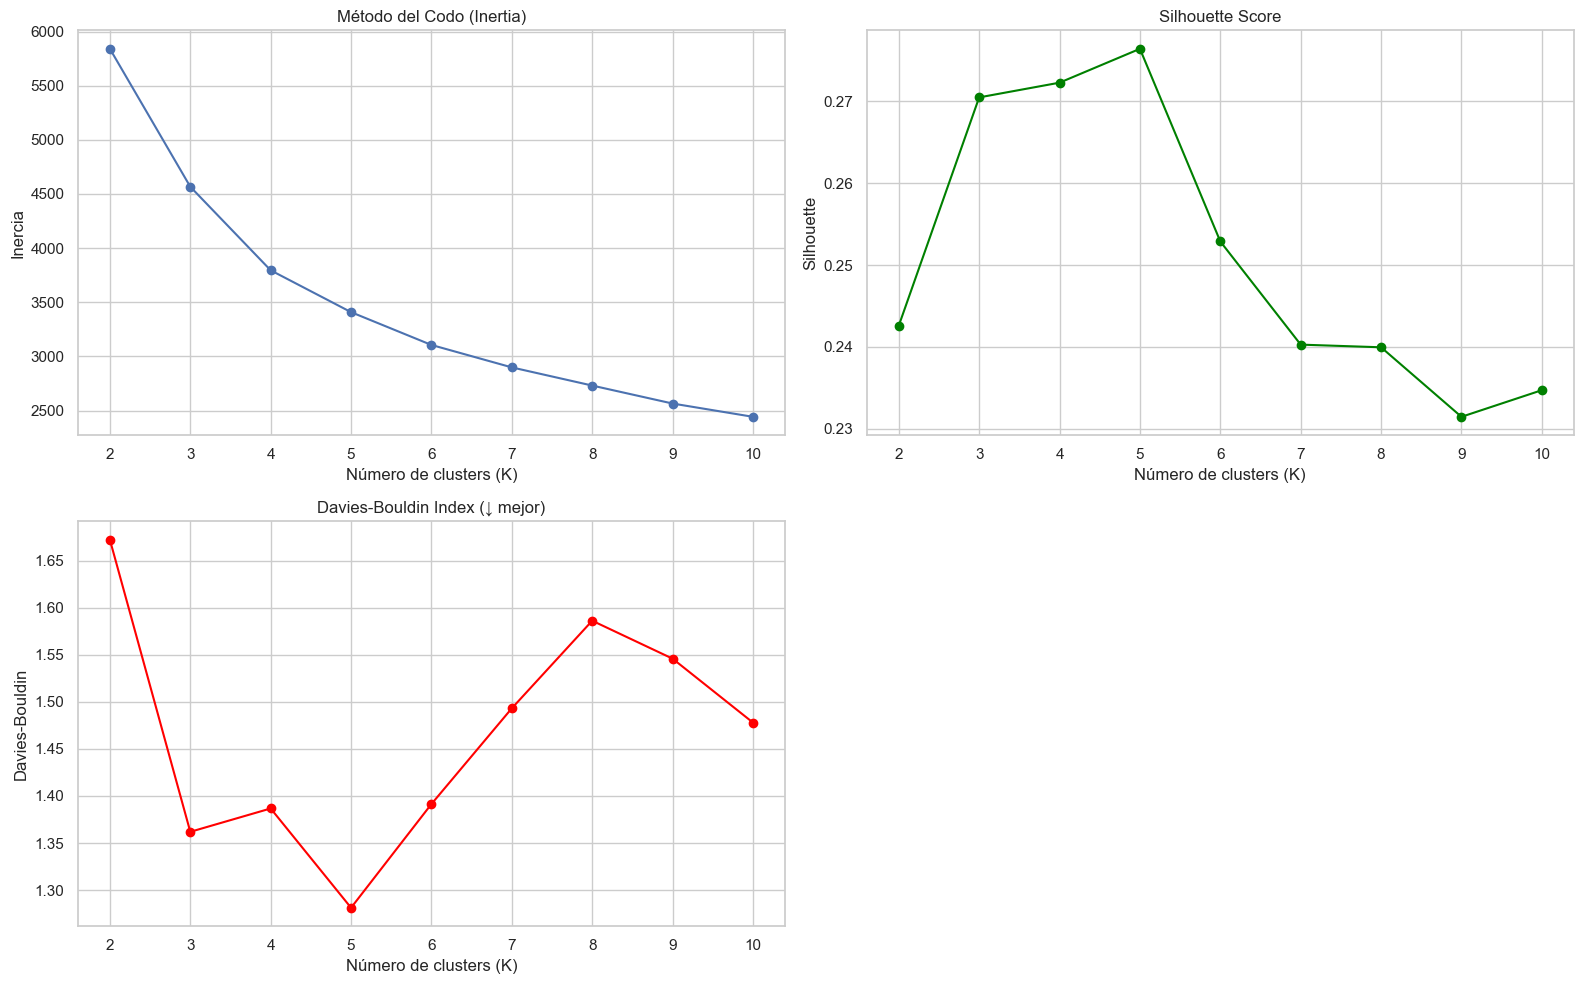

In [173]:
# 5. Evaluar métricas para distintos valores de K
K_range = range(2, 11)
inertias = []
silhouettes = []
davies = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    davies.append(davies_bouldin_score(X_scaled, labels))

# 6. Visualizar resultados
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Método del Codo (Inertia)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Inercia")

plt.subplot(2, 2, 2)
plt.plot(K_range, silhouettes, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Silhouette")

plt.subplot(2, 2, 3)
plt.plot(K_range, davies, marker='o', color='red')
plt.title("Davies-Bouldin Index (↓ mejor)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Davies-Bouldin")

plt.tight_layout()
plt.show()

### Paso 5. Aplicamos K-Means con el valor de K=5 obtenido de las graficas

In [174]:
# Aplicamos KMeans con K=4
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

# Asignar etiquetas de cluster al dataset
dataset['cluster'] = kmeans.labels_

##### _Pasos 4 y 5 Elección del número óptimo de clusters (K=5)_
Para determinar el número óptimo de clusters, se evaluaron varios criterios métricos de validación interna del modelo de KMeans:

1. __Método del Codo (Inercia):__
Se observó un cambio significativo en la pendiente al pasar de K=4 a K=5, indicando un punto de inflexión claro (el “codo”), a partir del cual la mejora en la inercia es menos pronunciada. Esto sugiere que cinco clusters explican suficientemente bien la variabilidad de los datos sin añadir complejidad innecesaria.

2. __Silhouette Score:__
El valor de la métrica alcanzó su máximo en K=5, lo cual indica que los clusters son más compactos y mejor separados entre sí en comparación con otras configuraciones. Esto respalda que los grupos generados con K=5 tienen una estructura coherente.

3. __Davies-Bouldin Index:__
Esta métrica, que penaliza la superposición entre clusters, también mostró su valor mínimo en K=5, reforzando que esta segmentación ofrece una mayor separación entre los grupos.

Dado que las tres métricas coinciden en que __K=5__ es el punto óptimo, se seleccionó este valor como el número definitivo de clusters para aplicar KMeans. Esta decisión garantiza una segmentación equilibrada, interpretable y alineada con la estructura real de los datos.

### Paso 6. Los centroides representan el perfil promedio de cada cluster. Son vectores con la media de cada variable física para los puntos de ese cluster.

In [175]:
# 6. Obtener los centroides (puntos medios) de cada cluster
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("\n #6. Centroides de los clusters:")
print(centroids)


 #6. Centroides de los clusters:
         Age    Gender  Weight (kg)  Height (m)        BMI  Fat_Percentage  \
0  49.564815  0.583333    77.876852    1.725185  26.432222       24.644907   
1  26.255507  0.215859    60.019824    1.667709  21.805154       26.805727   
2  37.757576  1.000000   114.576515    1.796591  35.953106       24.971970   
3  46.776000  0.328000    54.785600    1.696640  19.275120       26.257600   
4  29.020270  0.824324    85.095946    1.780743  27.133649       20.496622   

   Experience_Level  Workout_Frequency (days/week)  
0          1.856481                       3.398148  
1          1.740088                       3.242291  
2          1.492424                       2.939394  
3          1.792000                       3.312000  
4          2.162162                       3.689189  


In [176]:
for i, row in centroids.iterrows():
 print(f"\nPerfil del Cluster {i}:")
 print(f"\nEdad promedio: {row['Age']:.1f} años")
 print(f"Porcentaje de género masculino: {row['Gender']*100:.1f}%␣ ↪(1=masculino, 0=femenino)")
 print(f"Peso promedio: {row['Weight (kg)']:.1f} kg")
 print(f"Altura promedio: {row['Height (m)']:.2f} m")
 print(f"IMC promedio: {row['BMI']:.1f}")
 print(f"Porcentaje de grasa corporal promedio: {row['Fat_Percentage']:.1f}%")
 print(f"Nivel de experiencia promedio: {row['Experience_Level']:.1f}")
 print(f"Frecuencia de entrenamiento promedio: {row['Workout_Frequency (days/week)']:.1f} días por semana")
 print("----------------------------------------------------------------------------------")


Perfil del Cluster 0:

Edad promedio: 49.6 años
Porcentaje de género masculino: 58.3%␣ ↪(1=masculino, 0=femenino)
Peso promedio: 77.9 kg
Altura promedio: 1.73 m
IMC promedio: 26.4
Porcentaje de grasa corporal promedio: 24.6%
Nivel de experiencia promedio: 1.9
Frecuencia de entrenamiento promedio: 3.4 días por semana
----------------------------------------------------------------------------------

Perfil del Cluster 1:

Edad promedio: 26.3 años
Porcentaje de género masculino: 21.6%␣ ↪(1=masculino, 0=femenino)
Peso promedio: 60.0 kg
Altura promedio: 1.67 m
IMC promedio: 21.8
Porcentaje de grasa corporal promedio: 26.8%
Nivel de experiencia promedio: 1.7
Frecuencia de entrenamiento promedio: 3.2 días por semana
----------------------------------------------------------------------------------

Perfil del Cluster 2:

Edad promedio: 37.8 años
Porcentaje de género masculino: 100.0%␣ ↪(1=masculino, 0=femenino)
Peso promedio: 114.6 kg
Altura promedio: 1.80 m
IMC promedio: 36.0
Porcentaje de

#### __🔵Cluster 0 — "Adultos entrenadores medios"__

* Edad promedio: 49.6 años

* Género: 58% hombres / 42% mujeres

* Peso: 77.9 kg — Altura: 1.73 m — IMC: 26.4

* Grasa corporal: 24.6% — Experiencia: 1.86

* Frecuencia de entrenamiento: 3.4 días/semana

* _Interpretación: Usuarios de edad madura, con un perfil físico equilibrado, algo entrenados, y una rutina estable. Mezcla moderada de hombres y mujeres._

#### __🟡Cluster 1 — "Usuarios jóvenes y poco entrenados (predominio femenino)"__

* Edad promedio: 26.3 años

* Género: 22% hombres / 78% mujeres

* Peso: 60.0 kg — Altura: 1.67 m — IMC: 21.8

* Grasa corporal: 26.8% — Experiencia: 1.74

* Frecuencia de entrenamiento: 3.2 días/semana

* _Interpretación: Principalmente mujeres jóvenes con bajo peso, pero con un porcentaje graso relativamente alto. Baja masa muscular y nivel medio-bajo de actividad._

#### __🔴Cluster 2 — "Usuarios con obesidad y baja actividad (exclusivamente hombres)"__

* Edad promedio: 37.8 años

* Género: 100% hombres

* Peso: 114.6 kg — Altura: 1.80 m — IMC: 36.0

* Grasa corporal: 25.0% — Experiencia: 1.49

* Frecuencia de entrenamiento: 2.9 días/semana

* _Interpretación: Grupo exclusivamente masculino, con sobrepeso severo, escasa experiencia y baja frecuencia de entrenamiento. Perfil más problemático en términos de salud física._


#### __🟢Cluster 3 — "Mayores delgados con masa muscular reducida (predominio femenino)"__

* Edad promedio: 46.8 años

* Género: 33% hombres / 67% mujeres

* Peso: 54.8 kg — Altura: 1.70 m — IMC: 19.3

* Grasa corporal: 26.3% — Experiencia: 1.79

* Frecuencia de entrenamiento: 3.3 días/semana

* _Interpretación: Perfil de usuarios mayores, con bajo peso pero alta grasa corporal — típico de pérdida de masa muscular. Predominan las mujeres._


#### __🟣Cluster 4 — "Usuarios jóvenes, musculados y en forma (mayoría hombres)"__

* Edad promedio: 29.0 años

* Género: 82% hombres / 18% mujeres

* Peso: 85.1 kg — Altura: 1.78 m — IMC: 27.1

* Grasa corporal: 20.5% (la más baja) — Experiencia: 2.16

* Frecuencia de entrenamiento: 3.7 días/semana (la más alta)

* _Interpretación: Grupo con mejores indicadores físicos. Hombres jóvenes con gran regularidad, experiencia alta y bajo porcentaje graso. Probablemente entrenamientos de fuerza o alta intensidad._

### Paso 7. Saber cuántas sesiones hay en cada cluster nos da una idea del tamaño relativo de cada grupo.


 #7. Cantidad de sesiones por cluster:
cluster
3    250
1    227
0    216
4    148
2    132
Name: count, dtype: int64


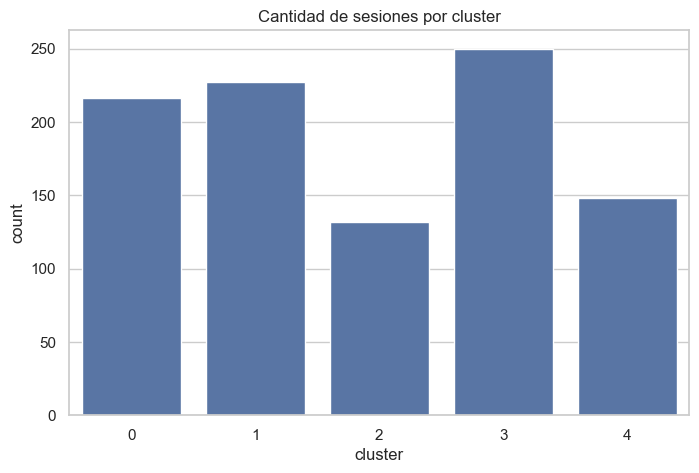

In [177]:
# 7. Ver cuántas sesiones hay en cada cluster
print("\n #7. Cantidad de sesiones por cluster:")
print(dataset['cluster'].value_counts())

# Gráfico de barras para cantidad de sesiones por cluster
plt.figure(figsize=(8, 5))
sns.countplot(x='cluster', data=dataset)
plt.title('Cantidad de sesiones por cluster')
plt.show()

### Paso 8. Visualización mediante Reducción de Dimensionalidad para ver cómo se agrupan visualmente los clusters

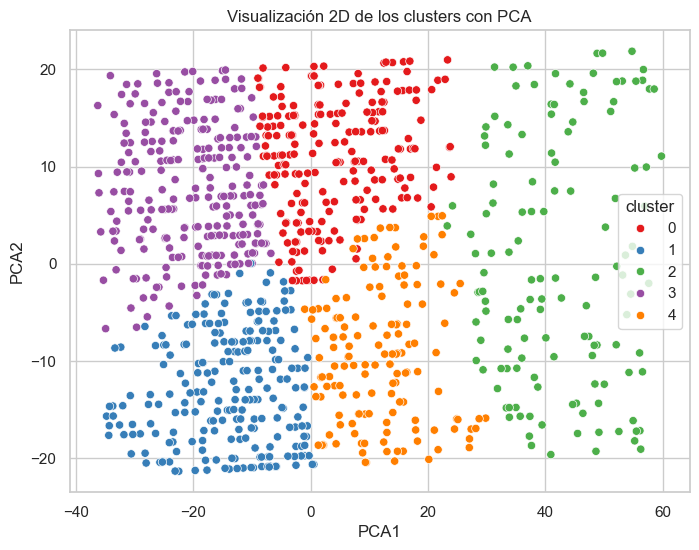

In [178]:
# Visualización tipo PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(X)

df_plot = pd.DataFrame(pca_components, columns=['PCA1', 'PCA2'])
df_plot['cluster'] = dataset['cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='cluster', data=df_plot, palette='Set1')
plt.title('Visualización 2D de los clusters con PCA')
plt.show()

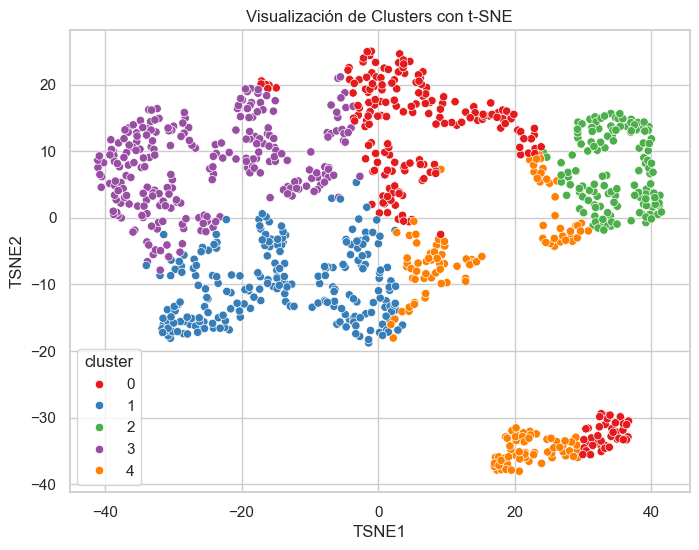

In [179]:
# Visualización tipo t-SNE

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_components = tsne.fit_transform(X)

df_tsne = pd.DataFrame(tsne_components, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = dataset['cluster']

plt.figure(figsize=(8, 6))
sns.scatterplot(x='TSNE1', y='TSNE2', hue='cluster', data=df_tsne, palette='Set1')
plt.title('Visualización de Clusters con t-SNE')
plt.show()

Con el objetivo de evaluar visualmente la distribución y la cohesión de los clusters generados por el algoritmo KMeans, se aplicaron dos técnicas de reducción de dimensionalidad: PCA (Análisis de Componentes Principales) y t-SNE (t-distributed Stochastic Neighbor Embedding).

La visualización mediante PCA mostró una separación razonablemente clara entre los diferentes grupos, lo que permite una interpretación más directa del reparto de los datos en un espacio bidimensional. Dado que PCA conserva la varianza lineal de los datos, es una herramienta útil para identificar agrupaciones generales de forma más ordenada y explicativa.

Por otro lado, la visualización mediante t-SNE reveló una estructura más compleja, con clusters más compactos y mejor definidos, aunque con formas menos intuitivas. Esta técnica es especialmente adecuada para detectar relaciones no lineales y capturar estructuras locales dentro de los datos, lo cual refuerza la validez de los grupos encontrados.

Conclusión:
Ambas representaciones confirman la coherencia del modelo con K = 5 clusters. Mientras que PCA es más adecuada para la interpretación general, t-SNE refuerza la solidez de la agrupación desde una perspectiva más detallada.

### Paso 9. Frecuencia de cada tipo de ejercicio por cluster


In [180]:
# Ver frecuencia de cada tipo de ejercicio por cluster
for tipo in ['Workout_HIIT', 'Workout_Strength', 'Workout_Yoga', 'Workout_Cardio']:
    print(f'\nFrecuencia media de {tipo} por cluster:')
    print(dataset.groupby('cluster')[tipo].mean())


Frecuencia media de Workout_HIIT por cluster:
cluster
0    0.236111
1    0.198238
2    0.250000
3    0.224000
4    0.243243
Name: Workout_HIIT, dtype: float64

Frecuencia media de Workout_Strength por cluster:
cluster
0    0.236111
1    0.286344
2    0.219697
3    0.288000
4    0.277027
Name: Workout_Strength, dtype: float64

Frecuencia media de Workout_Yoga por cluster:
cluster
0    0.282407
1    0.229075
2    0.234848
3    0.248000
4    0.222973
Name: Workout_Yoga, dtype: float64

Frecuencia media de Workout_Cardio por cluster:
cluster
0    0.245370
1    0.286344
2    0.295455
3    0.240000
4    0.256757
Name: Workout_Cardio, dtype: float64


## Paso 10. Interpretación de Clusters

#### Generamos un nuevo dataset para añadir al que ya teniamos una nueva columna Cluster. Cada sesion de entrenamiento tendrá asignado el Cluster al que representa

In [ ]:
dataset['cluster'] = kmeans.fit_predict(X_scaled)
dataset.to_csv("dataset_con_clusters.csv", index=False)


### 🔵 Cluster 0 – Usuarios intermedios y constantes

Este grupo está compuesto por personas de edad media-alta (49,6 años de promedio), con una ligera mayoría masculina (58,3%). Presentan un peso y una altura medios (77,9 kg y 1,73 m), con un IMC de 26,4, que indica una ligera tendencia al sobrepeso. Su porcentaje de grasa corporal (24,6%) también se sitúa en un rango medio.

En cuanto al comportamiento, destacan por tener una frecuencia de entrenamiento constante (3,4 días/semana) y un nivel de experiencia relativamente bajo (1,86). A pesar de no ser los más experimentados, su compromiso con la actividad física es consistente.

📌 Interpretación: Usuarios maduros, físicamente equilibrados, que entrenan con regularidad. Podrían beneficiarse de programas que mejoren su composición corporal, especialmente si el objetivo es reducir grasa o mejorar el IMC.

### 🟠 Cluster 1 – Usuarios jóvenes y principiantes

Formado por individuos jóvenes (26,3 años de media), este grupo cuenta con una mayoría femenina (solo un 21,6% son hombres). Son los más ligeros del conjunto, con un peso promedio de 60 kg y una altura de 1,67 m, lo que da lugar a un IMC de 21,8, dentro del rango saludable.

Tienen un porcentaje de grasa corporal algo más elevado de lo esperado (26,8%), lo que podría estar relacionado con su escaso nivel de experiencia (1,74) y una frecuencia de entrenamiento ligeramente inferior a la media (3,2 días/semana).

📌 Interpretación: Usuarios novatos, jóvenes y de constitución delgada, pero con margen de mejora a nivel de composición corporal. Representan un grupo ideal para planes de iniciación y educación deportiva.

### 🔴 Cluster 2 – Usuarios con sobrepeso y perfil masculino

Este grupo presenta un perfil físico muy marcado: edad media (37,8 años), 100% hombres, con un peso elevado (114,6 kg), una altura superior al resto (1,80 m) y un IMC de 36,0, que los sitúa claramente en la categoría de obesidad.

El porcentaje de grasa corporal (25%) no es el más alto, pero junto con su bajo nivel de experiencia (1,49) y su frecuencia de entrenamiento reducida (2,9 días/semana), indican un estilo de vida más sedentario o menos disciplinado.

📌 Interpretación: Usuarios con obesidad y escasa experiencia. Este grupo requiere intervenciones orientadas a la pérdida de peso, acompañadas de programas adaptados de entrenamiento progresivo.

### 🟣 Cluster 3 – Usuarios mayores y delgados

Compuesto por personas de edad elevada (46,8 años de media) y mayoría femenina (solo 32,8% hombres), este cluster tiene el menor peso (54,8 kg) y uno de los IMC más bajos (19,3), cerca del umbral de delgadez. Sin embargo, el porcentaje de grasa corporal (26,3%) es moderadamente alto, lo que sugiere una baja masa muscular.

Presentan un nivel de experiencia aceptable (1,79) y entrenan con frecuencia media (3,3 días/semana), lo cual sugiere un cierto hábito, pero sin progresión evidente.

📌 Interpretación: Personas mayores y físicamente frágiles, con composición corporal poco favorable a pesar de su bajo peso. Requieren entrenamiento orientado a ganancia muscular y mejora de fuerza funcional.

### 🟢 Cluster 4 – Usuarios avanzados y en forma

Este grupo está formado por usuarios jóvenes (29 años), con una mayoría masculina (82,4%). Tienen un peso medio-alto (85,1 kg) y una altura elevada (1,78 m), con un IMC de 27,1, que podría indicar sobrepeso, pero que se compensa con el porcentaje de grasa más bajo del conjunto (20,5%).

Son los más experimentados (2,16 de media) y los que entrenan con mayor frecuencia (3,7 días/semana), lo cual refleja una alta implicación con la actividad física.

📌 Interpretación: Usuarios avanzados, con buena condición física y hábitos sólidos. Representan un grupo modelo de adherencia y disciplina, que probablemente sigue una rutina estructurada y orientada al rendimiento.



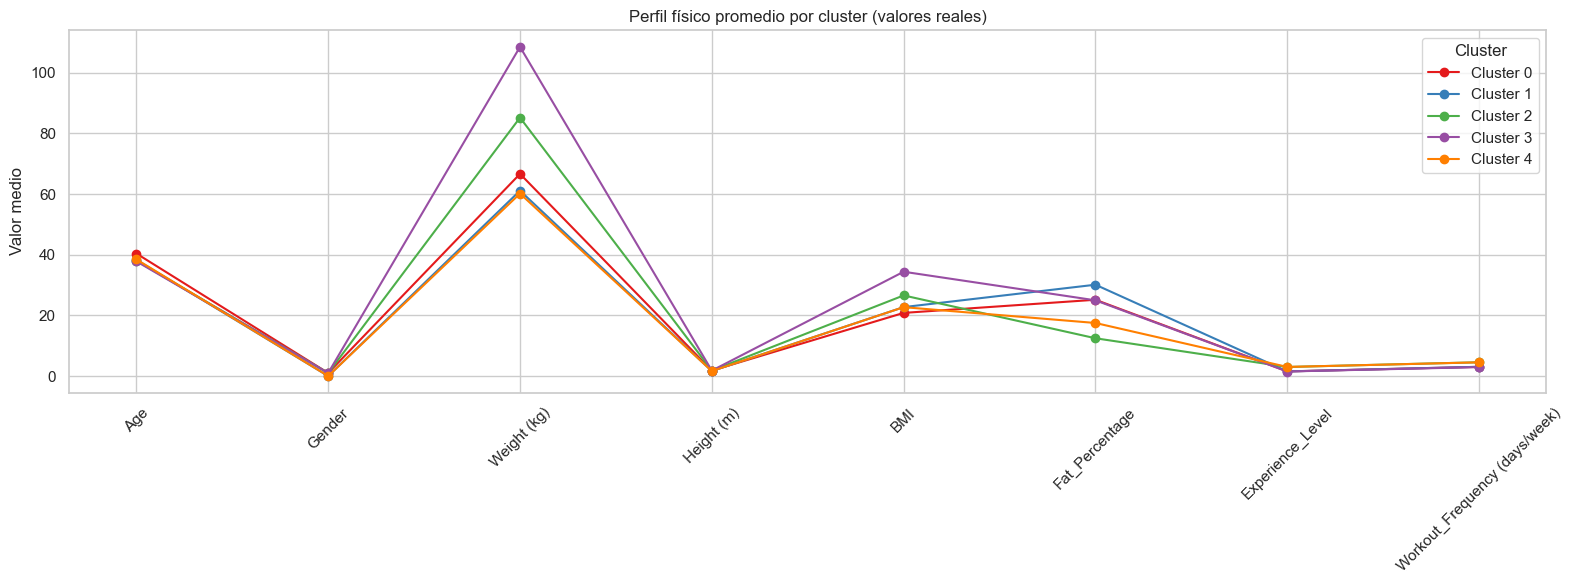

In [182]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculamos los centroides reales (no escalados)
centroids_real = dataset.groupby('cluster')[features].mean().T  # Transponemos para tener atributos en X

# Representación gráfica
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("Set1", n_colors=centroids_real.shape[1])

for i, col in enumerate(centroids_real.columns):
    plt.plot(centroids_real.index, centroids_real[col], marker='o', label=f'Cluster {col}', color=palette[i])

plt.title("Perfil físico promedio por cluster (valores reales)")
plt.ylabel("Valor medio")
plt.xticks(rotation=45)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

### Centroides Escalados

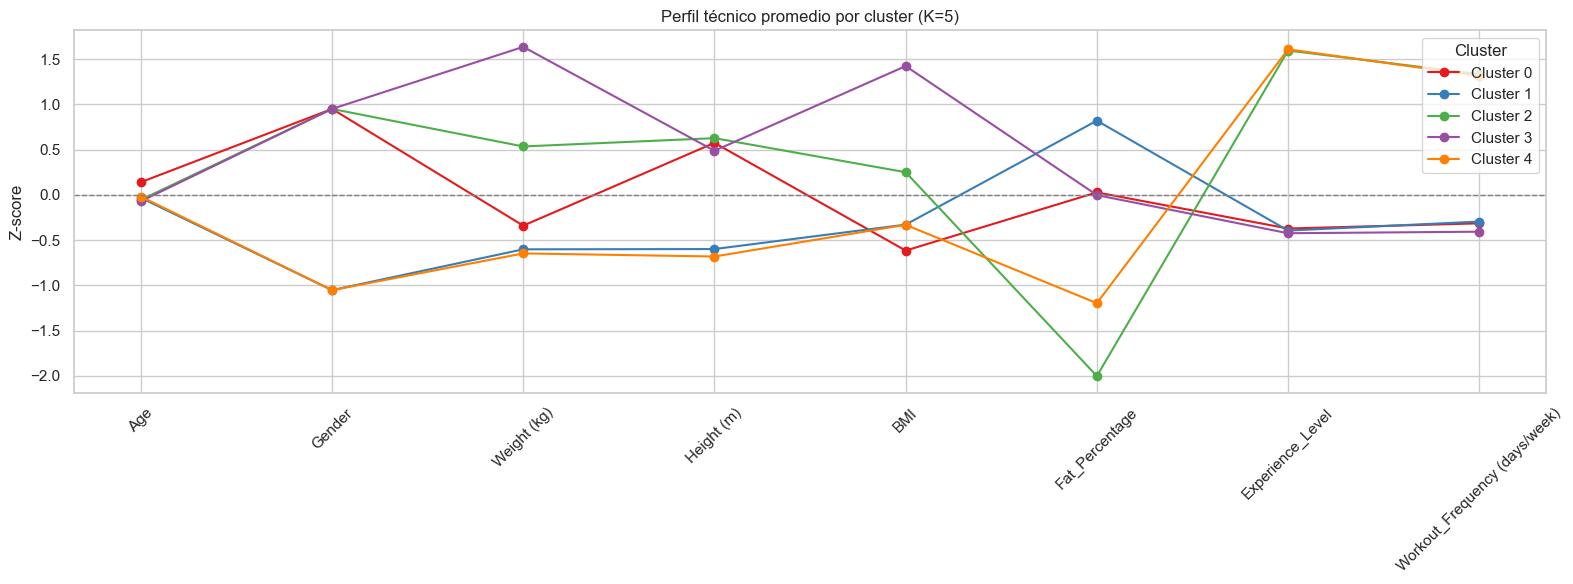


Centroides Z-score por cluster:
cluster                           0     1     2     3     4
Age                            0.14 -0.03 -0.05 -0.07 -0.02
Gender                         0.95 -1.05  0.95  0.95 -1.05
Weight (kg)                   -0.34 -0.60  0.54  1.64 -0.65
Height (m)                     0.58 -0.60  0.63  0.49 -0.68
BMI                           -0.61 -0.33  0.25  1.42 -0.33
Fat_Percentage                 0.03  0.82 -2.00 -0.00 -1.20
Experience_Level              -0.37 -0.39  1.60 -0.42  1.61
Workout_Frequency (days/week) -0.31 -0.29  1.33 -0.41  1.32


In [183]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Añadir cluster a los datos escalados
df_scaled = pd.DataFrame(X_scaled, columns=features)
df_scaled['cluster'] = dataset['cluster']

# Calcular la media estandarizada (Z-score) de cada atributo por cluster
centroids_z = df_scaled.groupby('cluster').mean().T

# Representación gráfica estilo perfil técnico (líneas con marcadores)
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")
palette = sns.color_palette("Set1", n_colors=centroids_z.shape[1])

for i, col in enumerate(centroids_z.columns):
    plt.plot(centroids_z.index, centroids_z[col], marker='o', label=f'Cluster {col}', color=palette[i])

plt.title("Perfil técnico promedio por cluster (K=5)")
plt.ylabel("Z-score")
plt.xticks(rotation=45)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.legend(title="Cluster", loc="upper right")
plt.tight_layout()
plt.show()

centroids_table = df_scaled.groupby('cluster').mean().T.round(2)
print("\nCentroides Z-score por cluster:")
print(centroids_table)